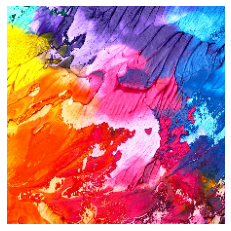

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

style_path = tf.keras.utils.get_file('style.jpg', 'http://bit.ly/2mGfZIq')

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image / 255
plt.axis('off')
plt.imshow(style_image)

tf.Tensor([0.02615643 0.42018676 0.06384039], shape=(3,), dtype=float32)


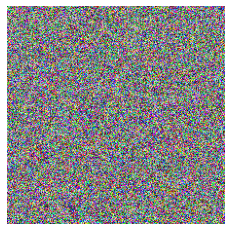

In [2]:
target_image = tf.random.uniform(style_image.shape)
print(target_image[0,0,:])
plt.axis('off')
plt.imshow(target_image)

In [3]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False, weights='imagenet')

for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [4]:
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]
vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

In [5]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [6]:
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize=(224,224))
style_image = style_image / 255

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis=0)
style_output = model(preprocess_input(style_batch * 255))

(1, 224, 224, 64)


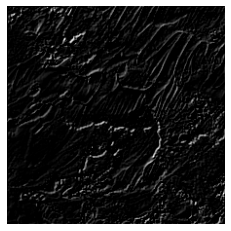

In [7]:
print(style_output[0].shape)
plt.axis('off')
plt.imshow(tf.squeeze(style_output[0][:,:,:,0], 0), cmap='gray')

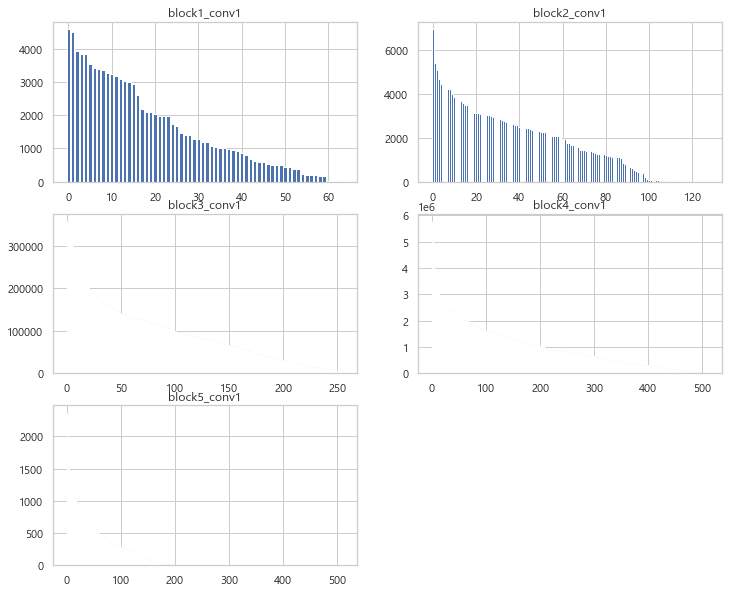

In [8]:
style_outputs = [gram_matrix(out) for out in style_output]

plt.figure(figsize=(12,10))
for c in range(5):
    plt.subplot(3,2,c+1)
    array = sorted(style_outputs[c].numpy()[0].tolist())
    array = array[::-1]
    plt.bar(range(style_outputs[c].shape[0]), array)
    plt.title(style_layers[c])
plt.show()

In [9]:
def get_outputs(image):
    image_batch = tf.expand_dims(image, axis=0)
    output = model(preprocess_input(image_batch * 255))
    outputs = [gram_matrix(out) for out in output]
    return outputs

def get_loss(outputs, style_outputs):
    return tf.reduce_sum([tf.reduce_mean((o-s)**2) for o, s in zip(outputs, style_outputs)])

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [10]:
opt = tf.optimizers.Adam(learning_rate=0.2, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = get_outputs(image)
        loss = get_loss(outputs, style_outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [11]:
import IPython.display as display
import time
import imageio

start = time.time()
image = tf.Variable(target_image)
epochs=50
steps_per_epoch = 100

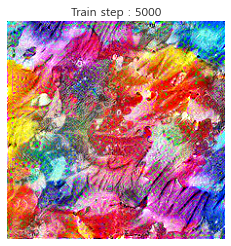

Total time : 1967.6


In [12]:
step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step+=1
        train_step(image)
    if n % 5 == 0 or n == epochs -1:
        imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
    display.clear_output(wait=True)
    plt.imshow(image.read_value())
    plt.title("Train step : {}".format(step))
    plt.axis('off')
    plt.show()

end = time.time()
print("Total time : {:.1f}".format(end-start))